# Negative Binomial Distribution

The negative binomial likelihood, typically looks like:

$$
NB(y_n | r, p) = {y_n + r - 1 \choose y_n}p^r (1-p)^{y_n}
$$

Intuitively, this is describing the likelihood of n successes given a system where you draw until n failures. It is parameterized by a probability of failure p, and a number of failures r, which enables it to be more expressive (in terms of variance) compared to typical binomial or poisson distributions. 

We typically want to assemble negative binomial models in some type of log-linear form. The logit transformation:

$$
\eta_n = \log (\frac{1-p_n}{p_n})
$$

implies we can recover p as 

$$
p = \frac{1}{1+e^{\eta_n}}
$$

and $(1-p)$ as:

$$
(1-p) = \frac{e^{\eta_n}}{1 + e^{\eta_n}}
$$

means that:

$$
NB(y_n | r, p) \propto p^r (1-p)^{y_n}
$$

or 

$$
NB(y_n | r, \eta_n) \propto (\frac{1}{1+e^{\eta_n}})^r (\frac{e^{\eta_n}}{1 + e^{\eta_n}})^{y_n}
$$

Which we simplify to:

$$
NB(y_n | r, \eta_n) \propto (\frac{1}{1+e^{\eta_n}})^r (\frac{e^{\eta_n}}{1 + e^{\eta_n}})^{y_n}
$$

or

$$
NB(y_n | r, \eta_n) \propto \frac{e^{\eta_n y_n}}{(1+e^\eta_n)^{y_n + r}}
$$



# The trouble with this form.

In order to do the Bayes thing, where we take a prior, and update based on the data we have:

$$
p(\theta | D) = \frac{p(D | \theta)p(\theta)}{p(D)}
$$

We would like to have a form where the posterior that we draw is in the same distribution as the prior distribution. PSW showed that you could do this via the following system:

$$
(\omega | \beta) \sim \text{PG}(n_i, x_i^T \beta)
$$

$$
(\beta | y, \omega) \sim \text{N}(m_\omega, V_\omega)
$$

Where the covariance
$$
V_\omega = (X^T \Omega X + B^{-1})^{-1}
$$

and the mean
$$
m_\omega = V_\omega(X^T \kappa + B^{-1}b)^{-1}
$$

are captured.


In [ ]:
class PolyaGammaSampler:


    def __init__(self):
        pass
    
    def sample_scalar(self, b, c, truncation=200):
        total = 0.0
        for k in range(1, truncation + 1):
            term_1 = np.random.gamma(b, 1.0)
            term_2 = (k - 0.5)**2
            term_3 = (c / (2 * np.pi))**2
            total += term_1 / (term_2 + term_3)
        
        return 0.5 * total / (np.pi**2)

    def sample(self, b_array, c_array, truncation=200):
        b_array = np.asarray(b_array)
        c_array = np.asarray(c_array)
        N = b_array.shape[0]
        omega = np.zeros(N)
        
        for n in range(N):
            omega[n] = self.sample_scalar(b_array[n], c_array[n], truncation=truncation)
        
        return omega

100%|██████████| 500/500 [00:15<00:00, 33.22it/s]


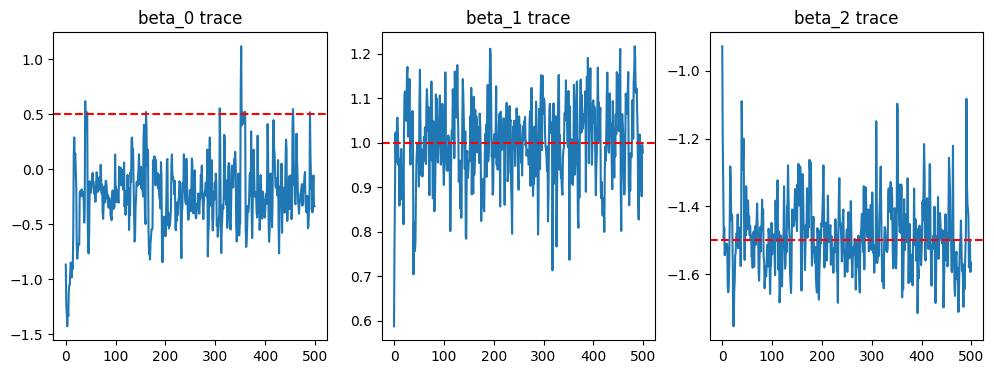

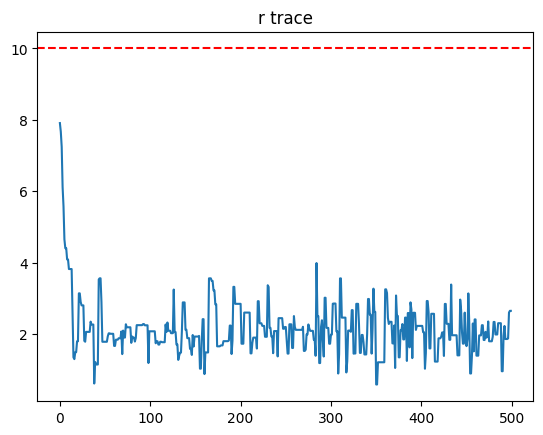

Posterior means:
beta: [-0.23207063  0.99898725 -1.48773706]
r: 2.1642816698595526
True beta: [ 0.5  1.  -1.5]
True r: 10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.special import gammaln
from tqdm import trange

# 1. Generate data
N = 200
X = np.hstack([np.ones((N, 1)), np.random.randn(N, 2)])
beta_true = np.array([0.5, 1.0, -1.5])
r_true = 10.0

eta = X @ beta_true
mu = np.exp(eta)
p = r_true / (r_true + mu)
y = nbinom.rvs(r_true, p)

# 2. PG sampler class


# 3. Metropolis update for r
def log_posterior_r(r, y, eta, a0=2.0, b0=0.1):
    mu = np.exp(eta)
    p = r / (r + mu)
    ll = np.sum(gammaln(y + r) - gammaln(r) + r * np.log(p) + y * np.log(1 - p))
    prior = (a0 - 1) * np.log(r) - b0 * r
    return ll + prior

# 4. Gibbs sampler setup
pg = PolyaGammaSampler()

Sigma0_inv = np.diag([0.1, 0.01, 0.01])  # stronger prior on intercept
mu0 = np.zeros(3)

num_iters = 500
beta_samples = []
r_samples = []

# Initialize
beta = np.zeros(3)
r = 8.0  # initial value

proposal_sd = 1.0  # proposal std for r

# 5. Gibbs + MH loop
for it in trange(num_iters):
    # Step 1: Sample PG variables
    eta = X @ beta
    b_vec = y + r
    c_vec = eta
    omega = pg.sample(b_vec, c_vec, truncation=200)
    
    # Step 2: Sample beta
    Omega = np.diag(omega)
    V_inv = X.T @ Omega @ X + Sigma0_inv
    V = np.linalg.inv(V_inv)
    
    m = V @ (X.T @ ((y - r) / 2) + Sigma0_inv @ mu0)
    
    beta = np.random.multivariate_normal(m, V)
    
    # Step 3: MH update for r
    eta = X @ beta
    log_r_old = log_posterior_r(r, y, eta)
    r_prop = np.abs(r + np.random.normal(0, proposal_sd))  # reflect to keep r > 0
    log_r_prop = log_posterior_r(r_prop, y, eta)
    
    alpha = np.exp(log_r_prop - log_r_old)
    if np.random.rand() < alpha:
        r = r_prop  # accept
    
    # Save
    beta_samples.append(beta)
    r_samples.append(r)

# 6. Convert to array
beta_samples = np.array(beta_samples)
r_samples = np.array(r_samples)

# 7. Plot beta
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for d in range(3):
    axes[d].plot(beta_samples[:, d])
    axes[d].axhline(beta_true[d], color='red', linestyle='--')
    axes[d].set_title(f'beta_{d} trace')
plt.show()

# 8. Plot r
plt.plot(r_samples)
plt.axhline(r_true, color='red', linestyle='--')
plt.title('r trace')
plt.show()

# 9. Print means
print("Posterior means:")
print("beta:", beta_samples.mean(axis=0))
print("r:", r_samples.mean())
print("True beta:", beta_true)
print("True r:", r_true)
